In [3]:
import os, cv2
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf

# Upload data to colab

In [4]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/CoNSeP')
try:
  os.makedirs(local_download_path)
except: pass

def load_files_to_colab(folder_id, des_path):
  # 2. Auto-iterate using the query syntax
  #    https://developers.google.com/drive/v2/web/search-parameters
  file_list = drive.ListFile(
      {'q': "'{}' in parents".format(folder_id)}).GetList()

  local_download_path = os.path.expanduser('~/CoNSeP/{}'.format(des_path))
  try:
    os.makedirs(local_download_path)
  except: pass

  for f in file_list:
    # 3. Create & download by id.
    #print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    #print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

In [5]:
import tqdm 
files_to_load = {
    'Test/Images': '1BLPlWV2rJju_4j4XvlQik14KQcFiBN5C',
    'Test/Labels': '1S_VX6w4kPEWTey7Syt7tRn2VFQzkEQXo',
    'Test/Overlay': '1gMuh5_YuWCOJ0UJoq3bIQQDgba_Yg2oj',
    'Train/Images': '1K23V4kYDDmo9kmnvn8PWRxW1XMSeO9nt',
    'Train/Labels': '1r74txX3KXY4VP7OayzbG0gNCX4AcnZnt',
    'Train/Overlay': '1_TjcKJ7121DcyJUn7w_UVLMEWA4_MXvR'
}

for des_path, folder_id in tqdm.tqdm(files_to_load.items()):
  load_files_to_colab(folder_id, des_path)

100%|██████████| 6/6 [03:29<00:00, 34.98s/it]


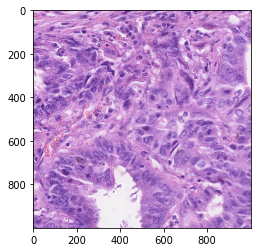

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/root/CoNSeP/Train/Images/train_3.png')
  
# Input Images
plt.imshow(img)

In [7]:
img.shape

(1000, 1000, 3)

# Read data

In [8]:
import scipy.io
# loead from file to dict
data = {
    'train_x': [mpimg.imread('/root/CoNSeP/Train/Images/train_{}.png'.format(i)) for i in range(1,28)],
    'train_y': np.array([scipy.io.loadmat('/root/CoNSeP/Train/Labels/train_{}.mat'.format(i))['type_map'] for i in range(1, 28)]),
    'test_x': [mpimg.imread('/root/CoNSeP/Test/Images/test_{}.png'.format(i)) for i in range(1,15)],
    'test_y': np.array([scipy.io.loadmat('/root/CoNSeP/Test/Labels/test_{}.mat'.format(i))['type_map'] for i in range(1, 15)])
}

In [9]:
data['train_x'][7].shape

(1000, 1000, 3)

# Remove 4th channel from images

In [10]:
# remove 4th channel from images
def rm_4th_chnl(dataset):
  for i in range(len(dataset)):
    img = dataset[i]
    # In case of grayScale images the len(img.shape) == 2
    if len(img.shape) > 2 and img.shape[2] == 4:
      #convert the image from RGBA2RGB
      dataset[i] = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR) 
  return np.array(dataset)

In [11]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Resize images

In [12]:
# resize images
def resize_image(data):
    img = data
    print(len(img))
    print('Original size',img[0].shape)
    # setting dim of the resize
    height = 256
    width = 256
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
    # Visualizing one of the images in the array
    original = res_img[0]
    display_one(original)

    return np.array(res_img)

27
Original size (1000, 1000, 3)
RESIZED (256, 256, 3)


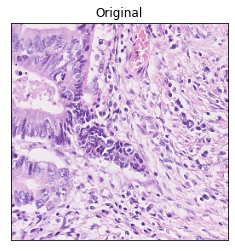

27
Original size (1000, 1000)
RESIZED (256, 256)


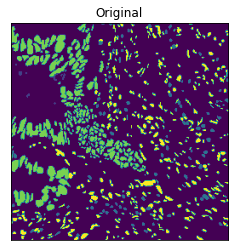

14
Original size (1000, 1000, 3)
RESIZED (256, 256, 3)


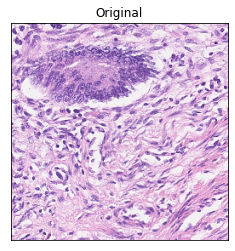

14
Original size (1000, 1000)
RESIZED (256, 256)


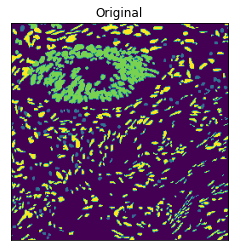

In [13]:
data['train_x'] =  resize_image(rm_4th_chnl(data['train_x']))
data['train_y'] =  resize_image(data['train_y'])

data['test_x'] =  resize_image(rm_4th_chnl(data['test_x']))
data['test_y'] =  resize_image(data['test_y'])


In [14]:
data['train_x'][7].shape

(256, 256, 3)

In [15]:
data['train_y'][7].shape

(256, 256)

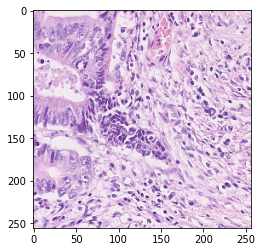

In [16]:
plt.imshow(data['train_x'][0])

# Data Augmentation

In [17]:
from scipy import ndimage
import cv2
import numpy as np
import random
import os

new_images = []
new_masks = []

# Flips the image horizontally with a probability.
def random_horizontal_flip(image, mask, flip_prob):
    p = random.uniform(0, 1.0)

    if p < flip_prob:
        return image[:, ::-1], mask[:, ::-1]
    else:
        return image, mask

# Flips the image vertically with a probability.
def random_vertical_flip(image, mask, flip_prob):
    p = random.uniform(0, 1.0)

    if p < flip_prob:
        return image[::-1, :], mask[::-1, :]
    else:
        return image, mask

# Crops a random region of the image.
def random_crop(image, mask, scale):
    height, width = image.shape[0:2]

    x_min = int(width * scale)
    y_min = int(height * scale)

    x = random.randint(0, width - x_min)
    y = random.randint(0, height - y_min)

    cropped_image,  cropped_mask = image[y: y+y_min, x: x+x_min], mask[y: y+y_min, x: x+x_min]
    return cv2.resize(cropped_image, (width, height)), cv2.resize(cropped_mask, (width, height))


# Randomly pads the image.
def random_padding(image, mask, padding_range):
    height, width = image.shape[0:2]

    padding_pixels = random.randint(0, padding_range)
    padded_image = cv2.copyMakeBorder(image, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_CONSTANT)
    padded_mask = cv2.copyMakeBorder(mask, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_CONSTANT)

    return cv2.resize(padded_image, (width, height)), cv2.resize(padded_mask, (width, height))

# Randomly rotates the image.
def random_rotate(image, mask, min_angle, max_angle):
    angle = random.randint(min_angle, max_angle)
    return ndimage.rotate(image, angle), ndimage.rotate(mask, angle)


# Constructs a data augmentation pipeline.
def sequential(image, mask, augmentation_prob):
    if random.uniform(0, 1.0) < augmentation_prob:
        image, mask = random_horizontal_flip(image, mask, flip_prob=0.6)
    if random.uniform(0, 1.0) < augmentation_prob:
        image, mask = random_vertical_flip(image, mask, flip_prob=0.6)

    return image, mask


# Apply data augmentation pipeline.
def data_augmentations(images, masks, num_of_augmentations, save_dir):
    for image, mask in zip(images, masks):
        for i in range(num_of_augmentations):
            random_image, random_mask = sequential(image, mask, augmentation_prob=0.8)
            #cv2.imwrite(os.path.join(save_dir, str(counter)+'.jpg'), random_image)
            new_images.append(random_image)
            new_masks.append(random_mask)

In [18]:
data_augmentations(data['train_x'], data['train_y'], 10, 'augmentations')

In [19]:
np.array(new_images).shape

(270, 256, 256, 3)

In [20]:
np.array(new_masks).shape

(270, 256, 256)

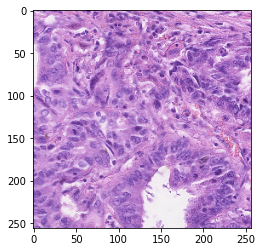

In [22]:
plt.imshow(new_images[27])

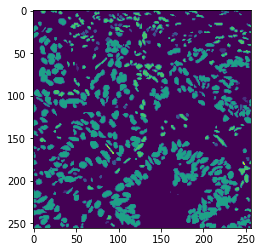

In [25]:
plt.imshow(new_masks[27])

In [27]:
data['train_x'] = np.concatenate((data['train_x'], np.array(new_images)))
data['train_y'] = np.concatenate((data['train_y'], np.array(new_masks)))

In [28]:
data['train_x'].shape

(297, 256, 256, 3)

In [29]:
data['train_y'].shape

(297, 256, 256)

# Segmentation Model

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [32]:
import tensorflow.keras
SM_FRAMEWORK = tensorflow.keras
import segmentation_models as sm
sm.set_framework('tf.keras')
#tensorflow.keras.backend.set_image_data_format('channels_last')

In [44]:
# define optomizer
optim = tensorflow.keras.optimizers.Adam(0.001)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

In [34]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tensorflow.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tensorflow.keras.callbacks.ReduceLROnPlateau(),
]

# Combine, shuffle, split and divide by 255.

In [35]:
# Combine
c = np.c_[data['train_x'].reshape(len(data['train_x']), -1), data['train_y'].reshape(len(data['train_y']), -1)]
# shuffle 
np.random.shuffle(c)
# split and divide x by 255.
data['train_x'] = (c[:, :data['train_x'].size//len(data['train_x'])].reshape(data['train_x'].shape))/255.
data['train_y'] = c[:, data['train_x'].size//len(data['train_x']):].reshape(data['train_y'].shape)

In [36]:
data['train_y'] =  to_categorical(data['train_y'])
data['test_y'] = to_categorical(data['test_y'])

In [37]:
print(data['train_x'].shape)
print(data['train_y'].shape)

(297, 256, 256, 3)
(297, 256, 256, 8)


In [38]:
# split train, val
[x_train, x_val] = np.split(data['train_x'], [int(.6 * len(data['train_x']))])
[y_train, y_val] = np.split(data['train_y'], [int(.6 * len(data['train_y']))])

In [39]:
y_train[40][0][0]

array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [40]:
# preprocess input
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Train Model

In [46]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=8, activation='softmax')
#model.compile(optim, sm.losses.categorical_crossentropy, [sm.metrics.f1_score])
model.compile(optim, sm.losses.categorical_focal_dice_loss, metrics)

# pretrain model decoder
model.fit(x_train, y_train, batch_size=16,
          #steps_per_epoch=len(x_train),
          callbacks=callbacks, 
          epochs=10,
          #validation_steps=len(x_val),
          validation_data=(x_val, y_val))

# release all layers for training
set_trainable(model, recompile=False) # set all layers trainable and recompile model

# continue training
history = model.fit(x_train, y_train, batch_size=16, 
                    #steps_per_epoch=len(x_train),
                    callbacks=callbacks, 
                    epochs=20,
                    #validation_steps=len(x_val),
                    validation_data=(x_val, y_val))

Epoch 1/10
12/12 [==============================] - 14s 725ms/step - loss: 0.9405 - iou_score: 0.0563 - f1-score: 0.0961 - val_loss: 0.9730 - val_iou_score: 0.0369 - val_f1-score: 0.0670
Epoch 2/10
12/12 [==============================] - 8s 691ms/step - loss: 0.8749 - iou_score: 0.0933 - f1-score: 0.1468 - val_loss: 0.9329 - val_iou_score: 0.0556 - val_f1-score: 0.0909
Epoch 3/10
12/12 [==============================] - 8s 694ms/step - loss: 0.8357 - iou_score: 0.1197 - f1-score: 0.1792 - val_loss: 0.9348 - val_iou_score: 0.0536 - val_f1-score: 0.0884
Epoch 4/10
12/12 [==============================] - 8s 691ms/step - loss: 0.8016 - iou_score: 0.1429 - f1-score: 0.2086 - val_loss: 0.9053 - val_iou_score: 0.0772 - val_f1-score: 0.1112
Epoch 5/10
12/12 [==============================] - 8s 692ms/step - loss: 0.7687 - iou_score: 0.1655 - f1-score: 0.2383 - val_loss: 0.9095 - val_iou_score: 0.0737 - val_f1-score: 0.1078
Epoch 6/10
12/12 [==============================] - 8s 693ms/step - l

# Plots

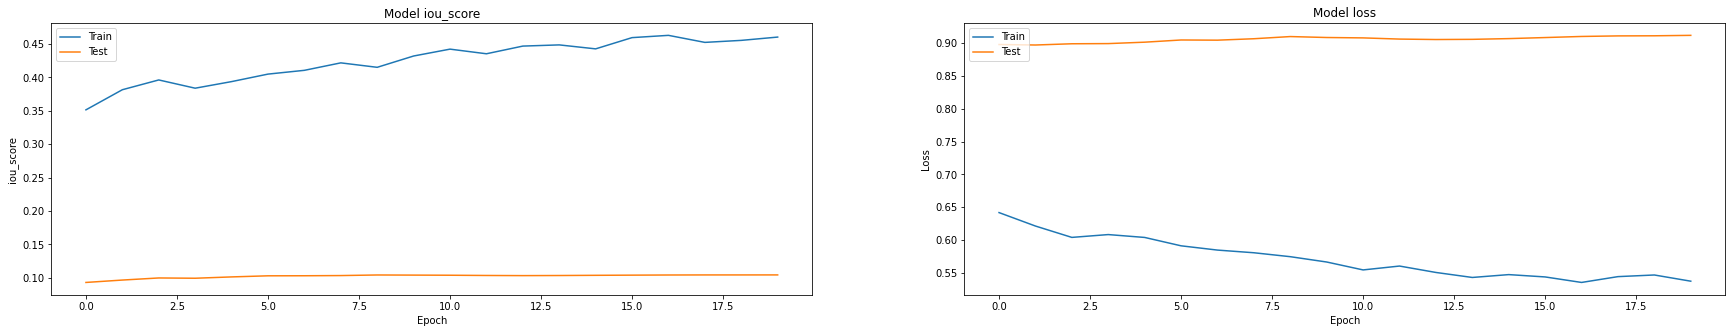

In [47]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Validation using test set

In [48]:
# load best weights
model.load_weights('best_model.h5')

In [49]:
scores = model.evaluate(x=data['test_x']/255., y=data['test_y'])

1/1 [==============================] - 2s 2s/step - loss: 0.9017 - iou_score: 0.0942 - f1-score: 0.1210


In [50]:
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.90165
mean iou_score: 0.094193
mean f1-score: 0.12096
